### Настройка параметров и выбор модели 

#### Импорт модулей

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib
import warnings
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,roc_curve,confusion_matrix,plot_confusion_matrix,classification_report,precision_score,recall_score,f1_score,accuracy_score,plot_roc_curve, confusion_matrix
warnings.filterwarnings('ignore')

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

#### Читаем датасеты

In [3]:
train = pd.read_csv('transform_train.csv')
test = pd.read_csv('transform_test.csv')

In [4]:
x_train = train.drop(columns=['Churn'])
y_train = train['Churn']
x_test = test.drop(columns=['Churn'])
y_test = test['Churn']

#### В проекте будем использовать следующие модели:
- Логистическая регрессия - вероятность входа в определенный класс
- Дерево решений - используя древовидную модель, покажем возможные последствия решения
- Случайный лес - случайным образом создает и объединяет несколько деревьев решений 

#### Создаем и обучаем модели

In [5]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

In [6]:
lr.fit(x_train,y_train)
dt.fit(x_train,y_train)
rf.fit(x_train,y_train)

C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Кросс-валидация

In [7]:
log_cv_0 = cross_val_score(lr,x_train,y_train,cv=5)*100
tree_cv_0 = cross_val_score(dt,x_train,y_train,cv=5)*100
forest_cv_0 = cross_val_score(rf,x_train,y_train,cv=5)*100

C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-pa

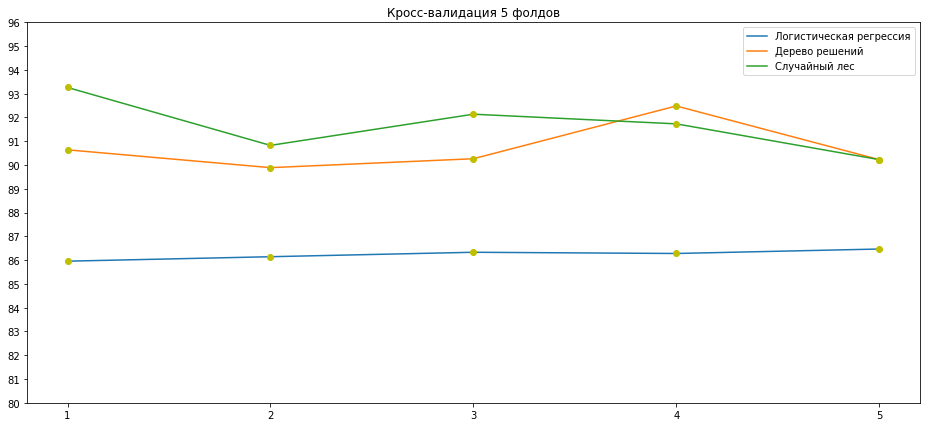

In [8]:
plt.figure(figsize=(16,7))
plt.title('Кросс-валидация 5 фолдов')
plt.plot([1,2,3,4,5],log_cv_0)
plt.plot([1,2,3,4,5],tree_cv_0)
plt.plot([1,2,3,4,5],forest_cv_0)
plt.plot([1,2,3,4,5],log_cv_0,'yo')
plt.plot([1,2,3,4,5],tree_cv_0,'yo')
plt.plot([1,2,3,4,5],forest_cv_0,'yo')
plt.legend(['Логистическая регрессия','Дерево решений','Случайный лес'])
plt.xticks(np.arange(1,6))
plt.yticks(np.arange(80,97,1))
plt.show()

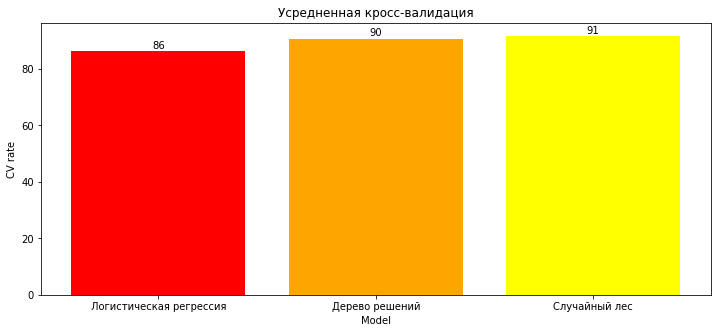

In [9]:
plt.figure(figsize=(12,5))
plt.title('Усредненная кросс-валидация')
plot = plt.bar(['Логистическая регрессия','Дерево решений','Случайный лес'],[log_cv_0.mean(),tree_cv_0.mean(),forest_cv_0.mean()],color=['red','orange','yellow'])
plt.ylabel('CV rate')
plt.xlabel('Model')
for i in plot:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.,
             1.002*height,'%d'% int(height),ha='center',va='bottom' )
plt.show()

#### Тюнинг гиперпараметров

Изменяя параметр модели на определенное значение, мы надеемся, что производительность нашей модели может улучшиться при классификации скорости перемешивания.

В этом проекте для экономии времени будет использоваться RandomizedSearch вместо GridSearch. 

In [10]:
def tuning(model,parameter,n_cv):
    random = RandomizedSearchCV(model, parameter, cv = n_cv)
    random.fit(x_train,y_train)
    best_param = random.best_params_
    
    return best_param

#### Параметр логистической регрессии
Проверяемый параметр:

- solver
- max iteration

In [18]:
log_param = {
    'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
    'penalty':['l2'],
    'C':[100,10,1.0,0.1,0.01]
}

log_best = tuning(lr,log_param,5)

C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\stroganov\AppData\Local\Continu

#### Параметр для дерева решений
Проверяемый параметр:

- criterion - выбрать лучший срез в дереве решений
- max_depths - длина дерева (от корня до листа) 

In [11]:
tree_param = {
    'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features':['sqrt','log2'],
    'min_samples_split': [i for i in range(2,21,2)],
    'min_samples_leaf': [i for i in range(1,12)],
    'criterion':['gini','entropy']
}

tree_best = tuning(dt,tree_param,5)

#### Параметр для случайного леса
Проверяемый параметр:

- n_estimators - количество деревьев в лесу
- min_sample_split - минимальное количество выборок, необходимых для разделения внутреннего узла / условия.
- min_samples_leaf - минимальное количество выборок, необходимых для конечного узла / конца. 

In [12]:
forest_param = {
    'n_estimators': [10,100,1000],
    'min_samples_split': [i for i in range(2,21,2)],
    'min_samples_leaf': [i for i in range(1,12)],
    'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt','log2'],
    'criterion':['gini','entropy']
}

forest_best = tuning(rf,forest_param,5)

### Лучшие параметры из RandomizedSearch

In [19]:
print(log_best)

{'solver': 'newton-cg', 'penalty': 'l2', 'C': 1.0}


In [20]:
log_new = LogisticRegression(solver='newton-cg',penalty='l2',C=1.0)
log_new.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
print(tree_best)

{'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'gini'}


In [22]:
tree_new = DecisionTreeClassifier(min_samples_split=10,min_samples_leaf=2,max_features='log2',max_depth=50,criterion='entropy')
tree_new.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=50,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
print(forest_best)

{'n_estimators': 1000, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini'}


In [24]:
forest_new = RandomForestClassifier(n_estimators=1000,min_samples_split=18,min_samples_leaf=4,max_features='sqrt',max_depth=None,criterion='gini')
forest_new.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=18,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Сравнение параметров по умолчанию с результатом настройки гиперпараметров 

In [25]:
log_acc_0 = round(lr.score(x_test,y_test)*100,2)
log_acc_1 = round(log_new.score(x_test,y_test)*100,2)

print('Logistic regression accuracy with default parameter',log_acc_0,'%')
print('Logistic regression accuracy with hyperparameter tuning',log_acc_1,'%')
print('After tuning, accuracy improve by around',round(log_acc_1-log_acc_0,2),'%')

Logistic regression accuracy with default parameter 85.16 %
Logistic regression accuracy with hyperparameter tuning 85.76 %
After tuning, accuracy improve by around 0.6 %


In [27]:
tree_acc_0 = round(dt.score(x_test,y_test)*100,2)
tree_acc_1 = round(tree_new.score(x_test,y_test)*100,2)

print('Decision tree accuracy with default parameter',tree_acc_0,'%')
print('Decision tree accuracy with hyperparameter tuning',tree_acc_1,'%')
print('After tuning, accuracy improve by around',round(tree_acc_1-tree_acc_0,2),'%')

Decision tree accuracy with default parameter 92.05 %
Decision tree accuracy with hyperparameter tuning 90.1 %
After tuning, accuracy improve by around -1.95 %


In [28]:
forest_acc_0 = round(rf.score(x_test,y_test)*100,2)
forest_acc_1 = round(forest_new.score(x_test,y_test)*100,2)

print('Random forest accuracy with default parameter',forest_acc_0,'%')
print('Random forest accuracy with hyperparameter tuning',forest_acc_1,'%')
print('After tuning, accuracy improve by around',round(forest_acc_1-forest_acc_0,2),'%')

Random forest accuracy with default parameter 91.0 %
Random forest accuracy with hyperparameter tuning 92.2 %
After tuning, accuracy improve by around 1.2 %


### Сравнение модели после тюнинга гиперпараметров

#### Кросс-валидация

In [30]:
log_cv_1 = cross_val_score(log_new,x_train,y_train,cv=5)*100
tree_cv_1 = cross_val_score(tree_new,x_train,y_train,cv=5)*100
forest_cv_1 = cross_val_score(forest_new,x_train,y_train,cv=5)*100

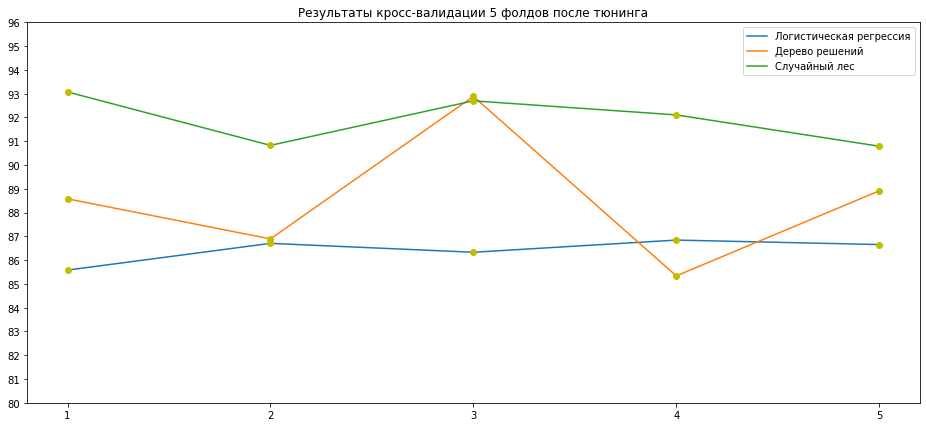

In [31]:
plt.figure(figsize=(16,7))
plt.title('Результаты кросс-валидации 5 фолдов после тюнинга')
plt.plot([1,2,3,4,5],log_cv_1)
plt.plot([1,2,3,4,5],tree_cv_1)
plt.plot([1,2,3,4,5],forest_cv_1)
plt.plot([1,2,3,4,5],log_cv_1,'yo')
plt.plot([1,2,3,4,5],tree_cv_1,'yo')
plt.plot([1,2,3,4,5],forest_cv_1,'yo')
plt.legend(['Логистическая регрессия','Дерево решений','Случайный лес'])
plt.xticks(np.arange(1,6))
plt.yticks(np.arange(80,97,1))
plt.show()

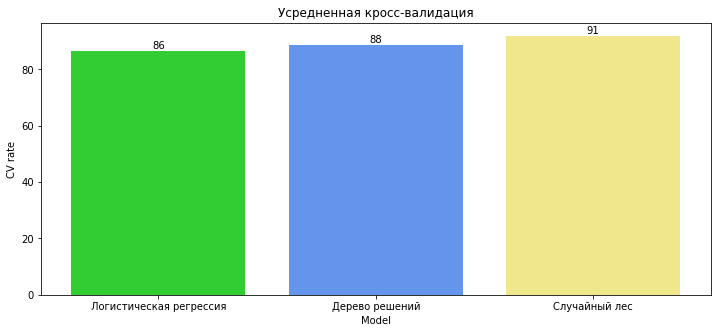

In [32]:
plt.figure(figsize=(12,5))
plt.title('Усредненная кросс-валидация')
plot = plt.bar(['Логистическая регрессия','Дерево решений','Случайный лес'],[log_cv_1.mean(),tree_cv_1.mean(),forest_cv_1.mean()],color=['limegreen','cornflowerblue','khaki'])
plt.ylabel('CV rate')
plt.xlabel('Model')
for i in plot:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.,
             1.002*height,'%d'% int(height),ha='center',va='bottom' )
plt.show()

### Матрица ошибок

#### * * * в разработке * * *

### Результаты классификации

#### * * * в разработке * * *

### Recall

Recall positive (sensitivity): $\displaystyle \frac {TP} {TP + FN}$

Recall negative (specificity): $\displaystyle \frac {TN} {TN + FP}$

In [37]:
log_recall_pos = recall_score(y_test,log_new.predict(x_test),pos_label=1)
log_recall_neg = recall_score(y_test,log_new.predict(x_test),pos_label = 0)
tree_recall_pos = recall_score(y_test,tree_new.predict(x_test),pos_label=1)
tree_recall_neg = recall_score(y_test,tree_new.predict(x_test),pos_label = 0)
forest_recall_pos = recall_score(y_test,forest_new.predict(x_test),pos_label=1)
forest_recall_neg = recall_score(y_test,forest_new.predict(x_test),pos_label = 0)

In [38]:
pd.DataFrame({'Logistic':[log_recall_pos,log_recall_neg],'Decision Tree':[tree_recall_pos,tree_recall_neg],'Random Forest':[forest_recall_pos,forest_recall_neg]},index=['churn','non churn'])

,Logistic,Decision Tree,Random Forest
churn,0.242105,0.484211,0.473684
non churn,0.959790,0.970280,0.996503


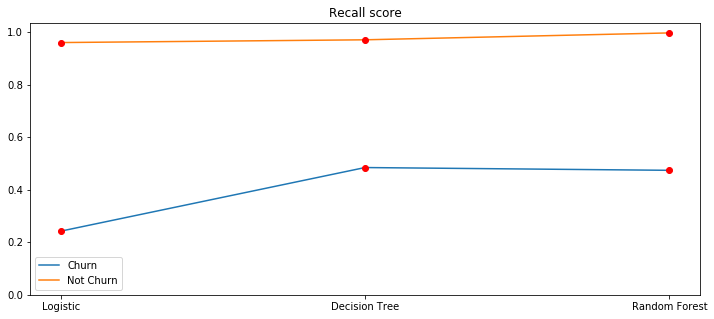

In [39]:
plt.figure(figsize=(12,5))
plt.title('Recall score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_recall_pos,tree_recall_pos,forest_recall_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_recall_neg,tree_recall_neg,forest_recall_neg])
plt.legend(['Churn','Not Churn'])
plt.plot([log_recall_pos,tree_recall_pos,forest_recall_pos],'ro')
plt.plot([log_recall_neg,tree_recall_neg,forest_recall_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.show()

### Precision


Formula Precision Positive = $\displaystyle \frac {TP}{TP+FP}$ 

Formula Precision Negative = $ \displaystyle \frac {TN}{TN+FN}$ 

In [41]:
log_prec_pos = precision_score(y_test,log_new.predict(x_test),pos_label=1)
log_prec_neg = precision_score(y_test,log_new.predict(x_test),pos_label=0)
tree_prec_pos = precision_score(y_test,tree_new.predict(x_test),pos_label=1)
tree_prec_neg = precision_score(y_test,tree_new.predict(x_test),pos_label=0)
forest_prec_pos = precision_score(y_test,forest_new.predict(x_test),pos_label=1)
forest_prec_neg = precision_score(y_test,forest_new.predict(x_test),pos_label=0)

In [42]:
pd.DataFrame({'Logistic':[log_prec_pos,log_prec_neg],'Decision Tree':[tree_prec_pos,tree_prec_neg],'Random Forest':[forest_prec_pos,forest_prec_neg]},index=['churn','non churn'])

,Logistic,Decision Tree,Random Forest
churn,0.500000,0.730159,0.957447
non churn,0.884058,0.918874,0.919355


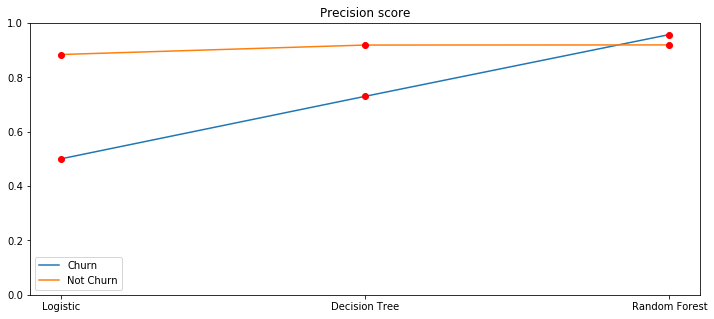

In [43]:
plt.figure(figsize=(12,5))
plt.title('Precision score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_prec_pos,tree_prec_pos,forest_prec_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_prec_neg,tree_prec_neg,forest_prec_neg])
plt.legend(['Churn','Not Churn'])
plt.plot([log_prec_pos,tree_prec_pos,forest_prec_pos],'ro')
plt.plot([log_prec_neg,tree_prec_neg,forest_prec_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.show()

##### Случайный лес дал более точный прогноз

### F1 Score

Formula = $\displaystyle 2 * (\frac {PrecisionP * RecallP }{PrecisionP + RecallP})$

In [45]:
f1_log_pos = f1_score(y_test,log_new.predict(x_test),pos_label=1)
f1_tree_pos = f1_score(y_test,tree_new.predict(x_test),pos_label=1)
f1_forest_pos = f1_score(y_test,forest_new.predict(x_test),pos_label=1)
f1_log_neg = f1_score(y_test,log_new.predict(x_test),pos_label=0)
f1_tree_neg = f1_score(y_test,tree_new.predict(x_test),pos_label=0)
f1_forest_neg = f1_score(y_test,forest_new.predict(x_test),pos_label=0)

In [46]:
pd.DataFrame({'Logistic':[f1_log_pos,f1_log_neg],'Decision Tree':[f1_tree_pos,f1_tree_neg],'Random Forest':[f1_forest_pos,f1_forest_neg]},index=['churn','not churn'])

,Logistic,Decision Tree,Random Forest
churn,0.326241,0.582278,0.633803
not churn,0.920369,0.943878,0.956376


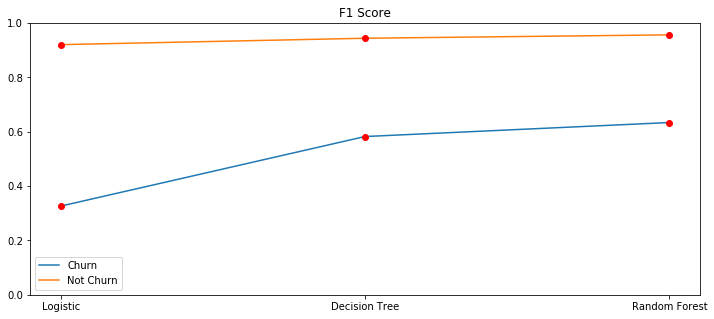

In [47]:
plt.figure(figsize=(12,5))
plt.title('F1 Score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[f1_log_pos,f1_tree_pos,f1_forest_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[f1_log_neg,f1_tree_neg,f1_forest_neg])
plt.plot([f1_log_pos,f1_tree_pos,f1_forest_pos],'ro')
plt.plot([f1_log_neg,f1_tree_neg,f1_forest_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.legend(['Churn','Not Churn'])
plt.show()

##### Логистическая регрессия показала худший результат по F1

### ROC AUC Score

Показывает, насколько модель способна различать классы. 

TPR = $\displaystyle \frac {TP}{TP+FN}$

FPR = $\displaystyle \frac {FP}{FP+TN}$

#### * * * в разработке * * *

#### Топ фичей по важности

In [50]:
importance = pd.Series(forest_new.feature_importances_,x_train.columns).sort_values(ascending=False)
top10 = importance.head(10)*100
top10

Day_charge        27.159719
CS_calls          16.696086
intl_Yes           8.298129
intl_No            7.343351
Intl_charge        6.506085
Eve_charge         6.466934
Intl_call          5.892023
Night_charge       3.739475
Day_call           2.975157
Account_length     2.851555
dtype: float64

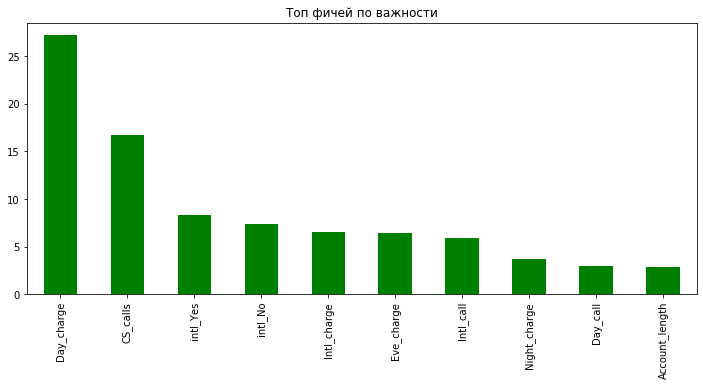

In [51]:
plt.figure(figsize=(12,5))
plt.title('Топ фичей по важности')
top10.plot(kind='bar',color=['green'])
plt.show()

Дневная оплата является наиболее определяющим фактором ухода клиентов, за которым следуют звонки в службу поддержки клиентов.

Многие уходящие клиенты считают, что дневная оплата компании слишком высока по сравнению с другими сетями.
Клиенты с большим количеством обращений в службу поддержки, как правило, уходят из-за проблем с клиентским опытом или жалоб, связанных с тарифами компании или сетью.
У международной службы компании могут возникать повторяющиеся проблемы, которые недовольны клиентом, как в сети, так и в ценах.

#### Рекомендации

1. Компании необходимо отслеживать клиентов, которые звонили в службу поддержки. Многие звонки в службу поддержки клиентов могут указывать на то, что с компанией что-то не так, что делает клиента недовольным.
2. Компания должна иметь хорошую команду по обслуживанию клиентов. В качестве связующего звена между компанией и клиентами хорошее обслуживание клиентов может дать клиенту хорошее представление о том, чем занимается компания. Плохое обслуживание == неудовлетворенность клиентов == более высокая вероятность оттока клиентов
3. Следите за дневной ставкой оплаты - компании необходимо убедиться, что она находится на разумном уровне. Слишком высокая цена == более высокий отток клиентов
4. Улучшение международного обслуживания - клиенты с международным тарифным планом, как правило, уходят больше.
5. Предлагать скидки клиентам в группе риска

### Анализ бизнеса на основе матрицы ошибок и отчета о классификации выбранной модели 

#### * * * в разработке * * *

#### Экспорт модели

In [56]:
joblib.dump(forest_new,'model')

['model']